<a href="https://colab.research.google.com/github/psakore/IMCFeedArbitration/blob/main/imc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scapy
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [13]:
import os
if not os.path.exists('feed_arbitrage.pcap'):
  !wget https://github.com/psakore/IMCFeedArbitration/raw/main/feed_arbitrage.pcap


In [14]:
import sys
from scapy.all import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, widgets, Output
from IPython.display import display


MAX_TIME = 9999999999999999

In [15]:
def process_packet(packet, data_dict):
    # Extract relevant information from the packet (symbol, seqno, timestamp)
    payload = packet.load.decode("utf-8")
    symbol = re.search(r"Symbol: (\w+)", payload).group(1)
    seqno = int(re.search(r"Seqno: (\d+)", payload).group(1))
    timestamp = int(packet.time * 1000000) # converting to int
    source_ip = packet[IP].src  # Get the source IP address

    # Add the packet information to the data dictionary
    key = "%s_%d" % (symbol, seqno)
    if key not in data_dict:
      data_dict[key] = {}
    data_dict[key][source_ip] = timestamp

In [38]:
def main(pcap_file, num_best):
    # Initialize a data dictionary to store packet information
    data_dict = {}

    # Iterate through packets, process them, and calculate metrics
    for packet in PcapReader(pcap_file):
        if packet.haslayer(UDP):
            process_packet(packet, data_dict)

    df = pd.DataFrame(data_dict).T
    df = df.reindex(sorted(df.columns), axis=1)
    df.index.name = 'Symbol_Seqno'
    df.fillna(MAX_TIME, inplace=True)
    df = df.astype(int)

    df['Fastest_Publisher'] = df.idxmin(axis=1)
    df['Min_Time'] = df.min(axis=1)

    #top_values = df['Fastest_Publisher'].value_counts().head(num_best).index.tolist()
    return df


In [46]:
df = main('feed_arbitrage.pcap', 2)
top_values = df['Fastest_Publisher'].value_counts()


                    10.10.10.1        10.10.10.2        10.10.10.3  \
Symbol_Seqno                                                         
APPL_0        1473411962413131  1473411962555594  1473411962542158   
APPL_1        1473411963499451  1473411963599473  1473411963590191   
APPL_2        1473411964411783  1473411964328186  1473411964527478   
APPL_3        1473411965364084  1473411965600693  1473411965591194   
APPL_4        1473411966589680  1473411966586622  1473411966320074   
...                        ...               ...               ...   
APPL_995      1473412957550574  1473412957348398  1473412957434642   
APPL_996      1473412958523923  1473412958528608  1473412958317482   
APPL_997      1473412959344292  1473412959581263  1473412959524173   
APPL_998      1473412960576111  1473412960410357  1473412960331070   
APPL_999      1473412961329239  1473412961594399  1473412961293294   

                    10.10.10.4 Fastest_Publisher          Min_Time  
Symbol_Seqno        

<ipython-input-38-01ca242d140c>:17: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['Min_Time'] = df.min(axis=1)


[49.0, 78.60000000000001, 89.4, 100.0]


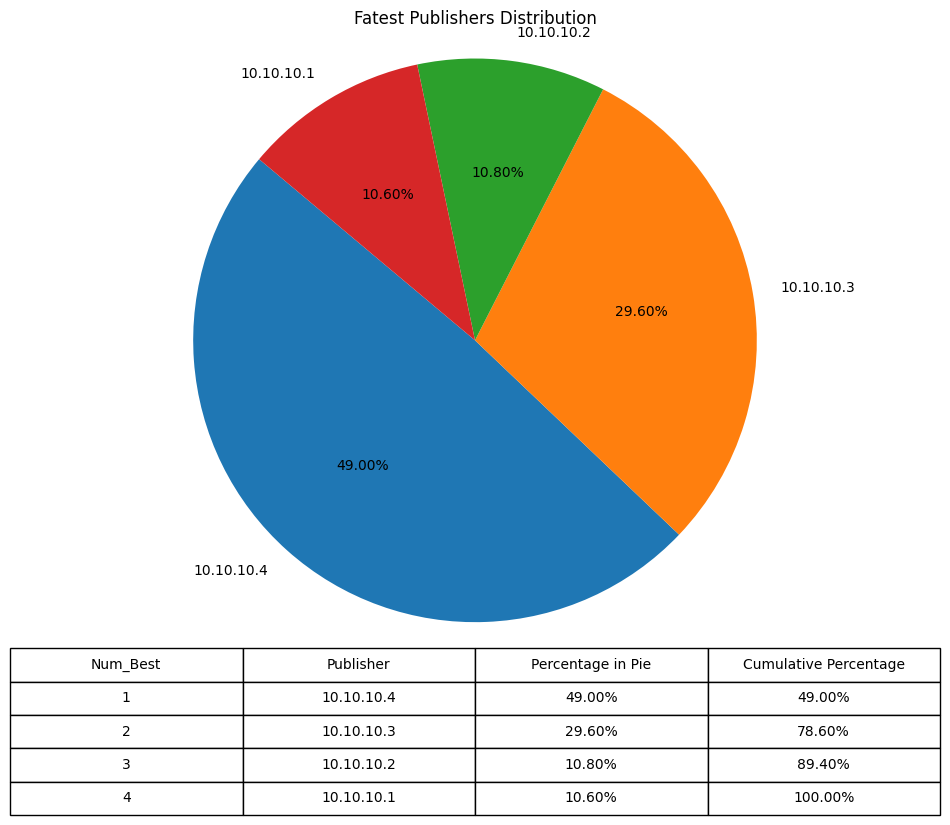

In [52]:
total_sum = top_values.sum()
cumulative_percentages = [sum(top_values.values[:i+1]) / total_sum * 100 for i in range(len(top_values))]

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_values, labels=top_values.index, autopct='%1.2f%%', startangle=140)
plt.title('Fatest Publishers Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Define the table data
table_data = [['Num_Best', 'Publisher', 'Percentage in Pie', 'Cumulative Percentage']]
for i, (label, value) in enumerate(zip(top_values.index, top_values.values)):
    table_data.append([i + 1, label, f'{value / total_sum * 100 :.2f}%', f'{cumulative_percentages[i]:.2f}%'])

# Create a table below the pie chart
table = plt.table(cellText=table_data[1:], loc='bottom', cellLoc='center', colLabels=table_data[0])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.5, 2)  # Adjust the table size

# Remove axis for the table
ax = plt.gca()
ax.axis('off')

# Display the pie chart and table
plt.show()

